# Water Quality Analysis - Davide Cantavenera
## Machine Learning for Brain and Cognition - Prof. Alberto Testolin

**Dataset:** Water Quality

### Project Overview

This project analyzes water quality data from 3276 different water bodies. The dataset contains 9 chemical and physical properties of water (ph, Hardness, Solids, Chloramines, Sulfate, Conductivity, Organic_carbon, Trihalomethanes, Turbidity) along with a binary label indicating whether the water is safe to drink.

Given the richness of this dataset, I decided to explore two complementary machine learning tasks. First, I tackle the main classification problem: can we predict whether water is potable based on its chemical properties? This is clearly the most important question from a practical standpoint. To answer it, I compare three different approaches: a simple linear model (Logistic Regression), a non-linear kernel method (SVM with RBF kernel), and an ensemble method (Random Forest).

Second, I explore a regression task by trying to predict the pH level from the other features. pH is a fundamental indicator of water quality, and understanding which factors influence it can provide valuable insights. For this task, I test both regularized linear models (Ridge and Lasso) and a non-linear ensemble (Random Forest Regressor).

Throughout the analysis, I pay careful attention to proper machine learning practices: handling missing values through imputation, standardizing features, addressing the class imbalance in the classification task with SMOTE, tuning hyperparameters through cross-validation, and evaluating all models on held-out test sets to get unbiased performance estimates.



## 1. Data loading and exploration

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression, Ridge, Lasso
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

from sklearn.metrics import (accuracy_score, confusion_matrix, ConfusionMatrixDisplay,
                             classification_report, roc_curve, auc, RocCurveDisplay,
                             mean_squared_error, r2_score, precision_score, recall_score, f1_score)

from imblearn.over_sampling import SMOTE


In [2]:
df = pd.read_csv('data/Dataset_Water.csv') #The CSV file must be in the same folder as this notebook.
print("Shape:", df.shape)
df.head()


Shape: (3276, 10)


,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


The dataset has **3276 rows** (samples) and **10 columns**. The first 9 columns are water quality features (ph, Hardness, Solids, Chloramines, Sulfate, Conductivity, Organic_carbon, Trihalomethanes, Turbidity) and the last column (`Potability`) is the binary target variable (0 or 1).

In [3]:
df.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,2785.000000,3276.000000,3276.000000,3276.000000,2495.000000,3276.000000,3276.000000,3114.000000,3276.000000,3276.000000
mean,7.080795,196.369496,22014.092526,7.122277,333.775777,426.205111,14.284970,66.396293,3.966786,0.390110
std,1.594320,32.879761,8768.570828,1.583085,41.416840,80.824064,3.308162,16.175008,0.780382,0.487849
min,0.000000,47.432000,320.942611,0.352000,129.000000,181.483754,2.200000,0.738000,1.450000,0.000000
25%,6.093092,176.850538,15666.690297,6.127421,307.699498,365.734414,12.065801,55.844536,3.439711,0.000000
50%,7.036752,196.967627,20927.833607,7.130299,333.073546,421.884968,14.218338,66.622485,3.955028,0.000000
75%,8.062066,216.667456,27332.762127,8.114887,359.950170,481.792304,16.557652,77.337473,4.500320,1.000000
max,14.000000,323.124000,61227.196008,13.127000,481.030642,753.342620,28.300000,124.000000,6.739000,1.000000


`describe()` shows count, mean, standard deviation, min, max and quartiles for each feature. We can notice that the count varies across columns - this means some features have missing values (for example `ph` has 2785 non-null values instead of 3276). The features also have very different scales: `Solids` ranges in the thousands while `ph` goes from 0 to 14. This is why we will need to standardize the data before training.

### Missing values

In [4]:
print("Missing values per column:")
print(df.isnull().sum())

Missing values per column:
ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64


Three features have missing values: `ph` (491 missing, ~15%), `Sulfate` (781, ~24%) and `Trihalomethanes` (162, ~5%).

A simpler approach would be to use `dropna()` to remove all rows with missing values. However, in this case that would mean losing up to ~24% of the dataset (781 rows out of 3276), which is a significant amount of data. Losing so many samples could reduce model performance and make the results less reliable, especially for the minority class which already has fewer examples.

For this reason, I chose **median imputation** (`SimpleImputer(strategy='median')`), which replaces each missing value with the median of that feature computed on the training set. The median is preferred over the mean because it is more robust to outliers.

### Distribution of features

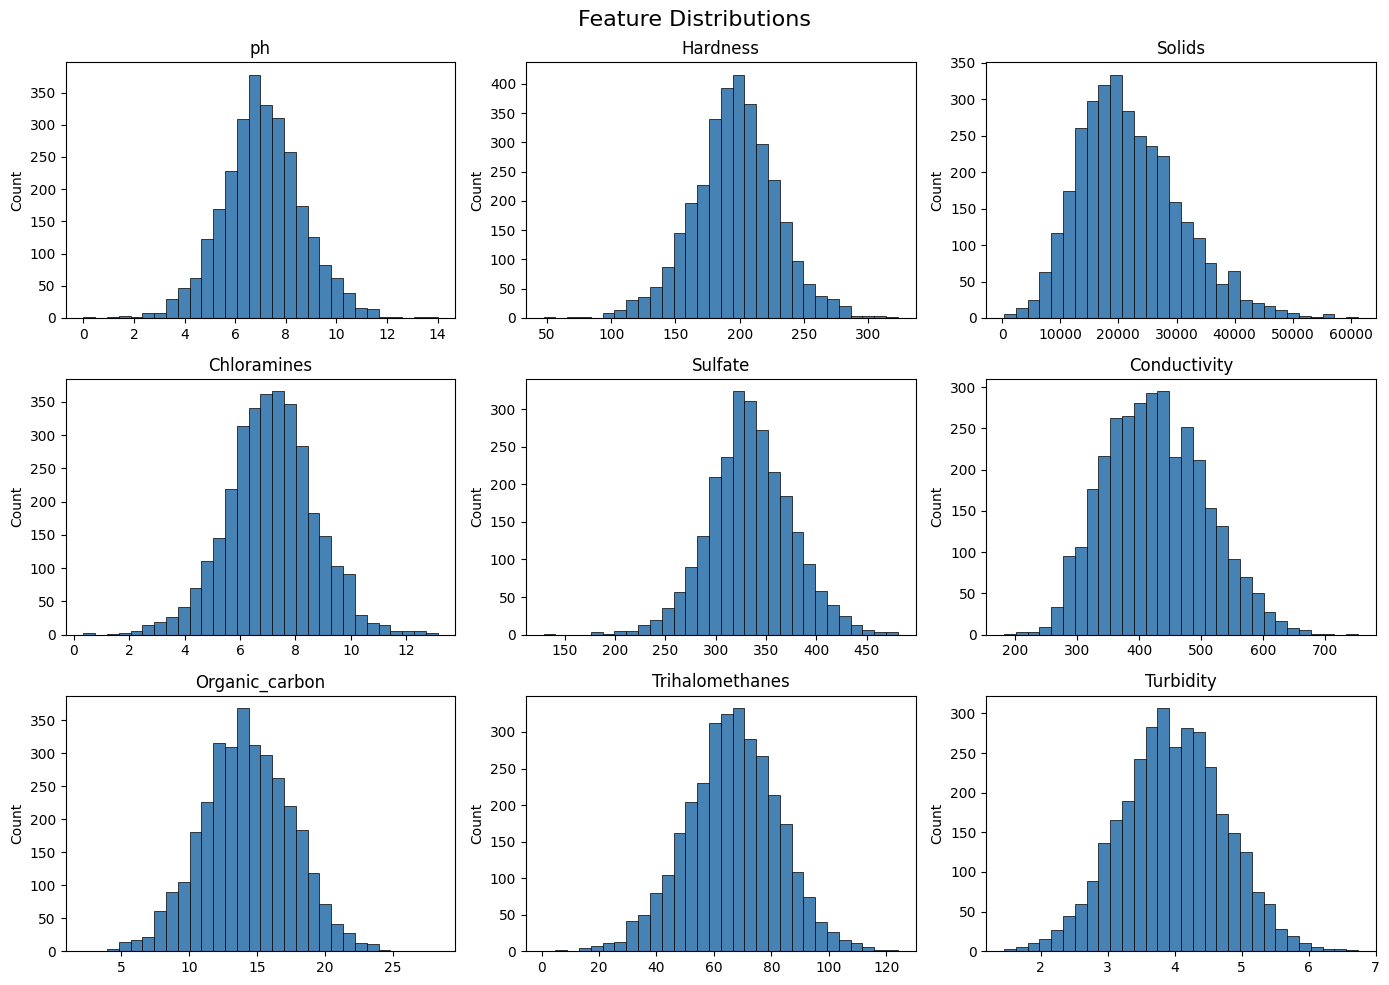

In [5]:
fig, axes = plt.subplots(3, 3, figsize=(14, 10))

for i, col in enumerate(df.columns[:-1]):
    ax = axes[i // 3, i % 3]
    _ = ax.hist(df[col].dropna(), bins=30, color='steelblue', edgecolor='black', linewidth=0.5)
    ax.set_title(col, size=12)
    ax.set_ylabel('Count')

plt.suptitle('Feature Distributions', size=16)
plt.tight_layout()
plt.show()

Most features have roughly normal distributions. `Solids` is slightly right-skewed. Since we'll standardize the features before feeding them to the models, this isn't a big concern.

### Target variable (classification)

Target distribution:
Potability
0    1998
1    1278
Name: count, dtype: int64

Potable %: 39.0%


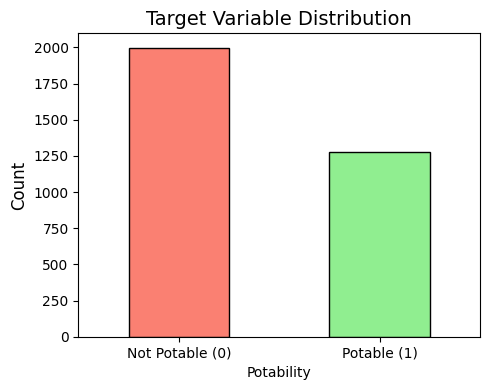

In [6]:
print("Target distribution:")
print(df['Potability'].value_counts())
print()
print("Potable %%: %.1f%%" % (df['Potability'].mean() * 100))

fig, ax = plt.subplots(figsize=(5, 4))
df['Potability'].value_counts().plot(kind='bar', color=['salmon', 'lightgreen'],
                                     edgecolor='black', ax=ax)
ax.set_xticklabels(['Not Potable (0)', 'Potable (1)'], rotation=0)
ax.set_ylabel('Count', size=12)
ax.set_title('Target Variable Distribution', size=14)
plt.tight_layout()
plt.show()

The target is imbalanced: about 61% not potable vs 39% potable. To deal with this we will use **SMOTE** (Synthetic Minority Oversampling Technique) to oversample the minority class during training, and also use `class_weight='balanced'` where supported.

### Correlation matrix

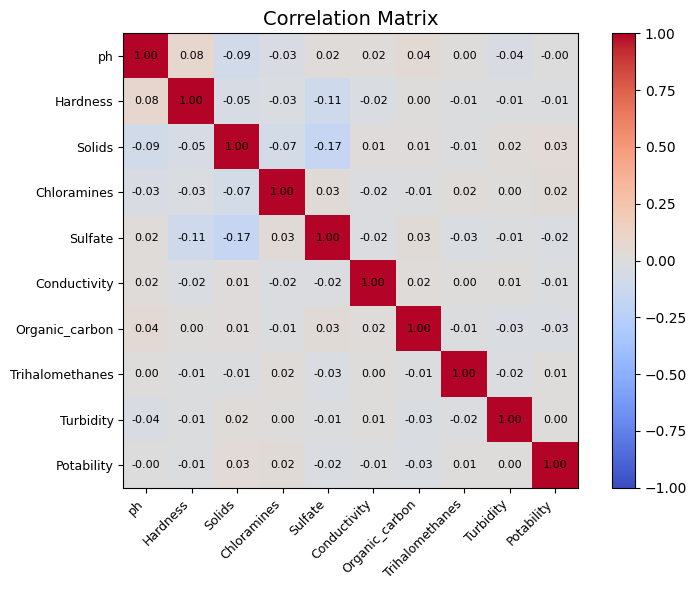

In [7]:
fig, ax = plt.subplots(figsize=(8, 6))
corr = df.corr()
im = ax.imshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
ax.set_xticks(range(len(corr.columns)))
ax.set_yticks(range(len(corr.columns)))
ax.set_xticklabels(corr.columns, rotation=45, ha='right', size=9)
ax.set_yticklabels(corr.columns, size=9)

# annotate
for i in range(len(corr)):
    for j in range(len(corr)):
        ax.text(j, i, "%.2f" % corr.iloc[i, j], ha='center', va='center', size=8)

plt.colorbar(im, ax=ax)
ax.set_title('Correlation Matrix', size=14)
plt.tight_layout()
plt.show()

All correlations are very weak (close to 0). This means no single feature is a strong linear predictor of potability, and there is no multicollinearity between features. Non-linear models like SVM with RBF kernel and Random Forest might be more suited for this data.

### Feature distributions by class

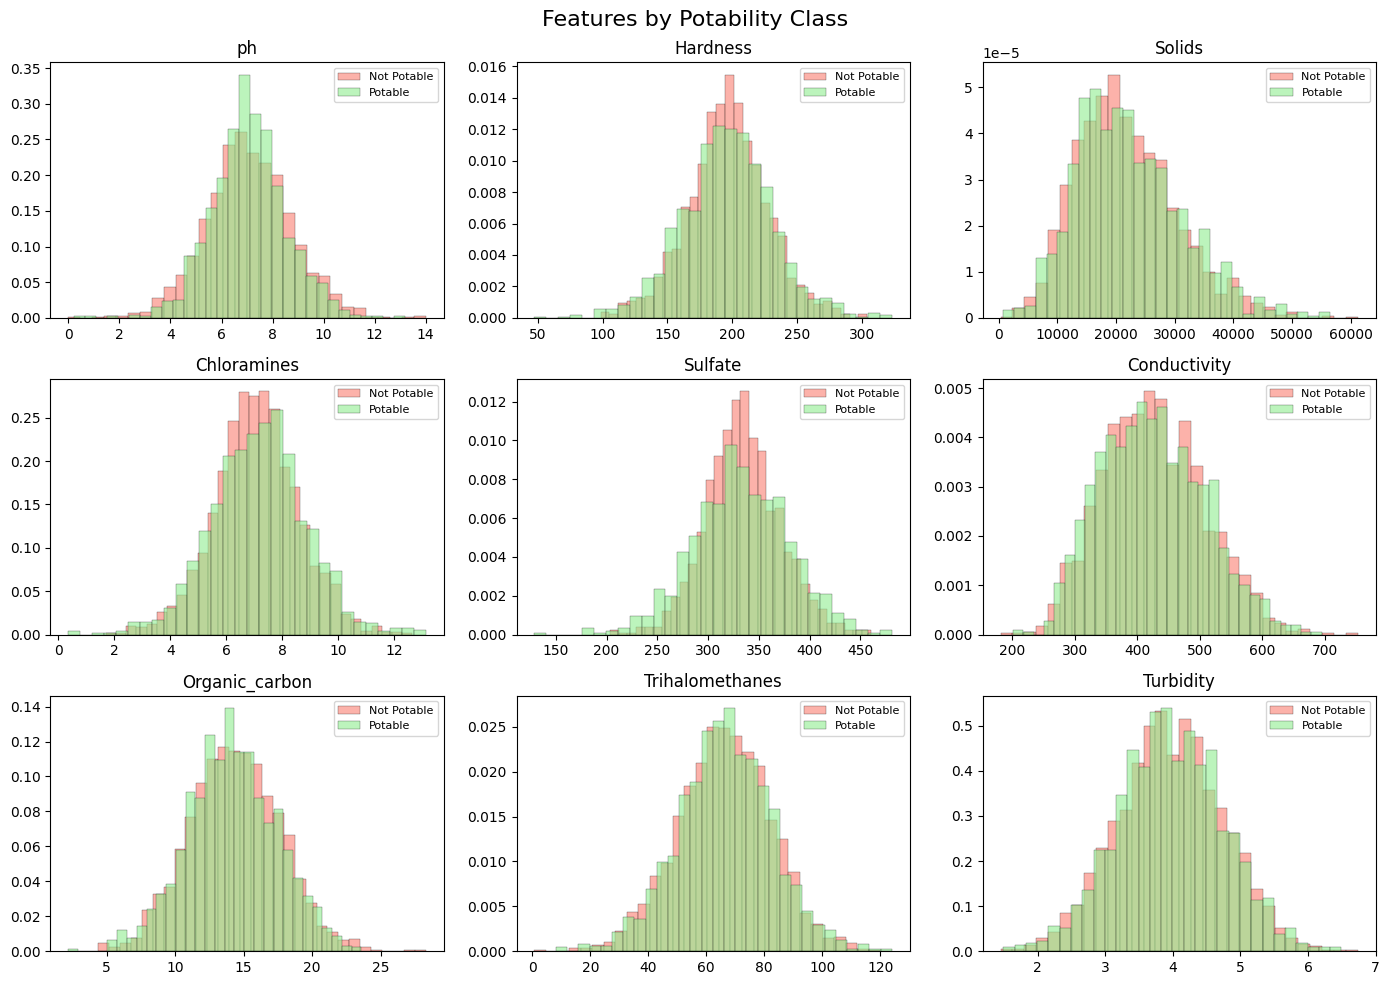

In [8]:
fig, axes = plt.subplots(3, 3, figsize=(14, 10))

for i, col in enumerate(df.columns[:-1]):
    ax = axes[i // 3, i % 3]
    for label, color, name in [(0, 'salmon', 'Not Potable'), (1, 'lightgreen', 'Potable')]:
        _ = ax.hist(df[df['Potability'] == label][col].dropna(), bins=30,
                    alpha=0.6, color=color, density=True, label=name, edgecolor='black', linewidth=0.3)
    ax.set_title(col, size=12)
    ax.legend(fontsize=8)

plt.suptitle('Features by Potability Class', size=16)
plt.tight_layout()
plt.show()

The distributions of the two classes overlap substantially for all features. This confirms that classification will be challenging. No single feature can cleanly separate potable from non-potable water.

### pH distribution (regression target)

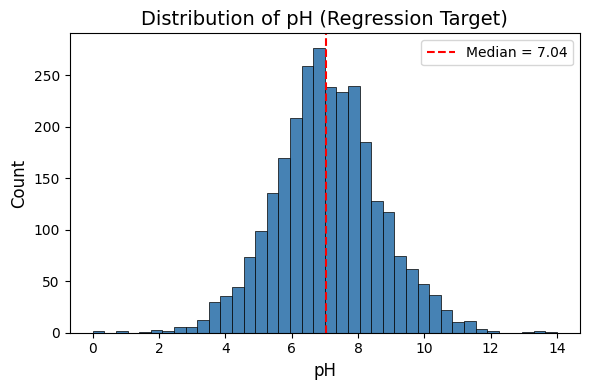

In [9]:
fig, ax = plt.subplots(figsize=(6, 4))
_ = ax.hist(df['ph'].dropna(), bins=40, color='steelblue', edgecolor='black', linewidth=0.5)
ax.axvline(df['ph'].median(), color='red', linestyle='--', linewidth=1.5,
           label='Median = %.2f' % df['ph'].median())
ax.set_xlabel('pH', size=12)
ax.set_ylabel('Count', size=12)
ax.set_title('Distribution of pH (Regression Target)', size=14)
ax.legend()
plt.tight_layout()
plt.show()

pH is roughly normally distributed around 7.0, spanning the full 0–14 range. This is a good continuous target for regression.

## 2. Preprocessing

**Steps:**
1. Handle missing values with median imputation
2. Standardize features (zero mean, unit variance). This is important for SVM and KNN
3. Split data into train (60%), validation (20%) and test (20%) using stratified sampling
4. Apply SMOTE on training data only to balance classes


We split the data into three parts: **train** (60%), **validation** (20%) and **test** (20%). The validation set is used for comparing models and tuning hyperparameters, while the test set is kept aside for the final unbiased evaluation.

We use `stratify=y` to make sure each split maintains the same proportion of potable/non-potable samples as the full dataset. This is important because the classes are imbalanced, and without stratification we could end up with a split where one class is under-represented.

In [10]:
# Prepare data for classification

X = df.drop('Potability', axis=1).values
y = df['Potability'].values

# Split: 80/20 first, then 75/25 on the 80% -> final split is 60/20/20
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.25, random_state=42, stratify=y_trainval)

print("Train: %d samples (%.0f%%)" % (len(X_train), len(X_train) / len(X) * 100))
print("Val:   %d samples (%.0f%%)" % (len(X_val), len(X_val) / len(X) * 100))
print("Test:  %d samples (%.0f%%)" % (len(X_test), len(X_test) / len(X) * 100))

Train: 1965 samples (60%)
Val:   655 samples (20%)
Test:  656 samples (20%)


Both imputation and standardization are fitted only on the training set (`fit_transform` on train, then just `transform` on validation and test). This avoids **data leakage**: if we used the whole dataset to compute medians or means, the model would indirectly "see" information from the test set during training, giving an overly optimistic evaluation.

In [11]:
# Impute missing values (fit on train only to avoid data leakage)
imputer = SimpleImputer(strategy='median')
X_train = imputer.fit_transform(X_train)
X_val = imputer.transform(X_val)
X_test = imputer.transform(X_test)

# Standardize features (fit on train only)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

print("Train mean (should be ~0):", np.round(X_train.mean(axis=0), 2))
print("Train std  (should be ~1):", np.round(X_train.std(axis=0), 2))

Train mean (should be ~0): [ 0. -0. -0.  0. -0.  0.  0. -0. -0.]
Train std  (should be ~1): [1. 1. 1. 1. 1. 1. 1. 1. 1.]


**SMOTE** (Synthetic Minority Oversampling Technique) generates synthetic samples for the minority class by interpolating between existing minority samples and their nearest neighbors. This is applied **only on the training set** - the validation and test sets are left untouched so that they reflect the real-world class distribution.

We combine SMOTE with `class_weight='balanced'` in the models as a double strategy to handle imbalance.

In [12]:
# Apply SMOTE to oversample minority class (only on training data)
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print("Before SMOTE - class 0: %d, class 1: %d" % ((y_train == 0).sum(), (y_train == 1).sum()))
print("After SMOTE  - class 0: %d, class 1: %d" % ((y_train_balanced == 0).sum(), (y_train_balanced == 1).sum()))

Before SMOTE - class 0: 1198, class 1: 767
After SMOTE  - class 0: 1198, class 1: 1198


For the regression task we predict **pH** from the other features. Since pH is our target, rows where pH is missing are dropped (we can't train on samples without a target value). The remaining features still get imputed and standardized the same way as before.

In [13]:
# Prepare data for regression (predict pH)
# predict pH using remaining features (excluding Potability)

df_ph = df.dropna(subset=['ph'])  # Drop rows with missing pH
X_ph = df_ph.drop(['Potability', 'ph'], axis=1).values
y_ph = df_ph['ph'].values

X_ph_trainval, X_ph_test, y_ph_trainval, y_ph_test = train_test_split(X_ph, y_ph, test_size=0.2, random_state=42)
X_ph_train, X_ph_val, y_ph_train, y_ph_val = train_test_split(X_ph_trainval, y_ph_trainval, test_size=0.25, random_state=42)

# Impute and standardize
imputer_ph = SimpleImputer(strategy='median')
scaler_ph = StandardScaler()
X_ph_train = scaler_ph.fit_transform(imputer_ph.fit_transform(X_ph_train))
X_ph_val = scaler_ph.transform(imputer_ph.transform(X_ph_val))
X_ph_test = scaler_ph.transform(imputer_ph.transform(X_ph_test))

print("Regression - Train: %d, Val: %d, Test: %d" % (len(X_ph_train), len(X_ph_val), len(X_ph_test)))


Regression - Train: 1671, Val: 557, Test: 557


## 3. Classification models

We try three classifiers that cover different approaches:

* **Logistic Regression** - a linear baseline. Uses `class_weight='balanced'` to handle class imbalance via a weighted loss function.
* **SVM with RBF kernel** - can learn non-linear decision boundaries using the kernel trick. Also supports `class_weight='balanced'`.
* **Random Forest** - ensemble of decision trees with bagging. Robust to overfitting and captures feature interactions.

These models were chosen because the data has weak linear correlations (suggesting non-linear models might help) and moderate class imbalance (requiring weighted losses or oversampling).


### 3.1 Baseline (default hyperparameters)

In [14]:
models = {
    'Logistic Regression': LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
    'SVM (RBF)': SVC(kernel='rbf', class_weight='balanced', probability=True, random_state=42),
    'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=42)
}

print("%-25s %10s %10s" % ("Model", "Train Acc", "Val Acc"))
print("-" * 47)

baseline_clf = {}
for name, model in models.items():
    model.fit(X_train_balanced, y_train_balanced)
    acc_tr = model.score(X_train_balanced, y_train_balanced)
    acc_val = model.score(X_val, y_val)
    baseline_clf[name] = {'acc_tr': acc_tr, 'acc_val': acc_val}
    print("%-25s %10.3f %10.3f" % (name, acc_tr, acc_val))


Model                      Train Acc    Val Acc
-----------------------------------------------
Logistic Regression            0.533      0.489
SVM (RBF)                      0.762      0.661
Random Forest                  1.000      0.661


The baseline results give us a starting point. We can see whether the models are learning something useful before investing time in tuning. Note that we train on the SMOTE-balanced data (`X_train_balanced`, `y_train_balanced`) but evaluate on the original validation set (`X_val`, `y_val`).

### 3.2 Hyperparameter tuning (GridSearchCV / RandomizedSearchCV)

We use 5-fold stratified cross-validation to find the best hyperparameters for each model. The scoring metric is `f1` because accuracy alone can be misleading with imbalanced data - a model could get ~61% accuracy by always predicting "not potable".

For Logistic Regression and SVM we use **GridSearchCV** (exhaustive search) because the parameter space is small. For Random Forest we use **RandomizedSearchCV** (random sampling) because the number of combinations is much larger.

In [15]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Logistic Regression
print("Tuning Logistic Regression...")
lr_grid = GridSearchCV(
    LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
    {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2'], 'solver': ['liblinear']},
    cv=cv, scoring='f1', n_jobs=-1
)
lr_grid.fit(X_train_balanced, y_train_balanced)
print("  Best params:", lr_grid.best_params_)
print("  Best CV F1: %.4f" % lr_grid.best_score_)


Tuning Logistic Regression...
  Best params: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
  Best CV F1: 0.5010


/opt/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/opt/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/opt/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1160: UserWarning: Inconsistent values: penalty=l1 with l1_ratio=0.0. penalty is deprecated. Please use l1_ratio only.
  wa

In [16]:
# SVM with RBF kernel
print("Tuning SVM (RBF)...")
svm_grid = GridSearchCV(
    SVC(kernel='rbf', class_weight='balanced', probability=True, random_state=42),
    {'C': [0.1, 1, 10, 50], 'gamma': ['scale', 'auto', 0.01, 0.1]},
    cv=cv, scoring='f1', n_jobs=-1
)
svm_grid.fit(X_train_balanced, y_train_balanced)
print("  Best params:", svm_grid.best_params_)
print("  Best CV F1: %.4f" % svm_grid.best_score_)


Tuning SVM (RBF)...
  Best params: {'C': 50, 'gamma': 'scale'}
  Best CV F1: 0.7165


In [17]:
# Random Forest
print("Tuning Random Forest...")
rf_grid = RandomizedSearchCV(
    RandomForestClassifier(class_weight='balanced', random_state=42),
    {'n_estimators': [100, 200, 300],
     'max_depth': [None, 5, 10, 15],
     'min_samples_split': [2, 5, 10],
     'min_samples_leaf': [1, 2, 4]},
    n_iter=30, cv=cv, scoring='f1', n_jobs=-1, random_state=42
)
rf_grid.fit(x_tr_sm, y_tr_sm)
print("  Best params:", rf_grid.best_params_)
print("  Best CV F1: %.4f" % rf_grid.best_score_)


Tuning Random Forest...


NameError: name 'x_tr_sm' is not defined

### 3.3 Tuned models - validation performance

In [ ]:
tuned_clf = {
    'Logistic Regression': lr_grid.best_estimator_,
    'SVM (RBF)': svm_grid.best_estimator_,
    'Random Forest': rf_grid.best_estimator_
}

print("%-25s %10s %10s %10s %10s" % ("Model", "Accuracy", "Precision", "Recall", "F1"))
print("-" * 67)

from sklearn.metrics import precision_score, recall_score, f1_score

tuned_val_clf = {}
for name, model in tuned_clf.items():
    y_pred = model.predict(x_val)
    acc = accuracy_score(y_val, y_pred)
    prec = precision_score(y_val, y_pred)
    rec = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    tuned_val_clf[name] = {'acc': acc, 'prec': prec, 'rec': rec, 'f1': f1}
    print("%-25s %10.3f %10.3f %10.3f %10.3f" % (name, acc, prec, rec, f1))


After tuning, we can see how the models perform on the validation set using all four metrics. Accuracy tells us the overall correctness, precision tells us how many of the "potable" predictions are correct, recall tells us how many actual potable samples we find, and F1 is the harmonic mean of precision and recall.

## 4. Regression models

For predicting pH we use:

* **Ridge Regression** - linear model with L2 regularization. Good baseline that prevents overfitting when features are weakly predictive.
* **Lasso Regression** - linear model with L1 regularization. Can perform automatic feature selection by shrinking some coefficients to zero.
* **Random Forest Regressor** - non-linear ensemble that can capture complex relationships between features.


### 4.1 Baseline

In [ ]:
models_reg = {
    'Ridge': Ridge(random_state=42),
    'Lasso': Lasso(random_state=42, max_iter=5000),
    'Random Forest': RandomForestRegressor(random_state=42)
}

print("%-25s %10s %10s %10s %10s" % ("Model", "Train R²", "Val R²", "Train RMSE", "Val RMSE"))
print("-" * 77)

baseline_reg = {}
for name, model in models_reg.items():
    model.fit(x_tr_r, y_tr_r)
    r2_tr = model.score(x_tr_r, y_tr_r)
    r2_val = model.score(x_val_r, y_val_r)
    rmse_tr = np.sqrt(mean_squared_error(y_tr_r, model.predict(x_tr_r)))
    rmse_val = np.sqrt(mean_squared_error(y_val_r, model.predict(x_val_r)))
    baseline_reg[name] = {'r2_tr': r2_tr, 'r2_val': r2_val}
    print("%-25s %10.4f %10.4f %10.4f %10.4f" % (name, r2_tr, r2_val, rmse_tr, rmse_val))


The baseline results already suggest that predicting pH will be very hard. The validation R² is close to 0 for the linear models, meaning they explain almost none of the variance. Random Forest has a higher training R² but a much lower validation R², which is a sign of overfitting - the model memorizes the training data but does not generalize well.

### 4.2 Hyperparameter tuning

In [ ]:
cv_reg = KFold(n_splits=5, shuffle=True, random_state=42)

# Ridge Regression
print("Tuning Ridge...")
ridge_gs = GridSearchCV(
    Ridge(random_state=42),
    {'alpha': [0.01, 0.1, 1, 10, 100, 1000]},
    cv=cv_reg, scoring='neg_mean_squared_error', n_jobs=-1
)
ridge_gs.fit(x_tr_r, y_tr_r)
print("  Best alpha: %s, CV RMSE: %.4f" % (ridge_gs.best_params_['alpha'], np.sqrt(-ridge_gs.best_score_)))

# Lasso Regression
print("\nTuning Lasso...")
lasso_gs = GridSearchCV(
    Lasso(random_state=42, max_iter=5000),
    {'alpha': [0.001, 0.01, 0.1, 1, 10]},
    cv=cv_reg, scoring='neg_mean_squared_error', n_jobs=-1
)
lasso_gs.fit(x_tr_r, y_tr_r)
print("  Best alpha: %s, CV RMSE: %.4f" % (lasso_gs.best_params_['alpha'], np.sqrt(-lasso_gs.best_score_)))

# Random Forest Regressor
print("\nTuning Random Forest Regressor...")
rf_reg_gs = RandomizedSearchCV(
    RandomForestRegressor(random_state=42),
    {'n_estimators': [100, 200, 300],
     'max_depth': [None, 5, 10, 15],
     'min_samples_split': [2, 5, 10],
     'min_samples_leaf': [1, 2, 4]},
    n_iter=30, cv=cv_reg, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42
)
rf_reg_gs.fit(x_tr_r, y_tr_r)
print("  Best params:", rf_reg_gs.best_params_)
print("  CV RMSE: %.4f" % np.sqrt(-rf_reg_gs.best_score_))


In [ ]:
tuned_reg = {
    'Ridge': ridge_gs.best_estimator_,
    'Lasso': lasso_gs.best_estimator_,
    'Random Forest': rf_reg_gs.best_estimator_
}

print("%-25s %10s %10s" % ("Model", "Val R²", "Val RMSE"))
print("-" * 47)

tuned_val_reg = {}
for name, model in tuned_reg.items():
    y_pred = model.predict(x_val_r)
    r2 = r2_score(y_val_r, y_pred)
    rmse = np.sqrt(mean_squared_error(y_val_r, y_pred))
    tuned_val_reg[name] = {'r2': r2, 'rmse': rmse}
    print("%-25s %10.4f %10.4f" % (name, r2, rmse))


## 5. Final evaluation on test set

Now we evaluate the tuned models on the held-out test set, which was never used during training or hyperparameter selection. This gives us an unbiased estimate of performance on new data.

### 5.1 Classification - test results

In [ ]:
print("%-25s %10s %10s %10s %10s" % ("Model", "Accuracy", "Precision", "Recall", "F1"))
print("-" * 67)

test_clf = {}
for name, model in tuned_clf.items():
    y_pred = model.predict(x_te)
    y_prob = model.predict_proba(x_te)[:, 1]
    acc = accuracy_score(y_te, y_pred)
    prec = precision_score(y_te, y_pred)
    rec = recall_score(y_te, y_pred)
    f1 = f1_score(y_te, y_pred)
    test_clf[name] = {'y_pred': y_pred, 'y_prob': y_prob,
                      'acc': acc, 'prec': prec, 'rec': rec, 'f1': f1}
    print("%-25s %10.3f %10.3f %10.3f %10.3f" % (name, acc, prec, rec, f1))


The test results show moderate performance overall. None of the models achieves very high accuracy, which is expected given how much the class distributions overlap. Recall (the ability to correctly identify potable water) tends to be higher than precision (the fraction of positive predictions that are actually correct), meaning the models flag many samples as potable even when they are not. The F1 score balances both metrics and gives us the most reliable comparison.

### 5.2 Confusion matrices

The confusion matrix shows how many samples were correctly classified (on the diagonal) and how many were misclassified (off the diagonal). The rows represent the actual class and the columns the predicted class.

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, (name, res) in enumerate(test_clf.items()):
    cm = confusion_matrix(y_te, res['y_pred'])
    disp = ConfusionMatrixDisplay(cm, display_labels=['Not Potable', 'Potable'])
    disp.plot(ax=axes[i], cmap='Blues', colorbar=False)
    axes[i].set_title(name, size=12)

plt.suptitle('Confusion Matrices (Test Set)', size=14)
plt.tight_layout()
plt.show()


Looking at the confusion matrices, we can see that the main source of error is false positives (non-potable water predicted as potable) and false negatives (potable water predicted as non-potable). The models tend to misclassify a significant number of samples in both directions, which is consistent with the overlapping feature distributions we saw earlier.

### 5.3 ROC curves

The ROC curve plots the True Positive Rate (recall) against the False Positive Rate at different classification thresholds. The area under the curve (AUC) summarizes overall performance: 0.5 = random guessing, 1.0 = perfect classifier. A model that is better at distinguishing the two classes will have a curve closer to the top-left corner.

In [ ]:
fig, ax = plt.subplots(figsize=(7, 6))

for name, res in test_clf.items():
    fpr, tpr, _ = roc_curve(y_te, res['y_prob'])
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, linewidth=2, label='%s (AUC = %.3f)' % (name, roc_auc))

ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
ax.set_xlabel('False Positive Rate', size=12)
ax.set_ylabel('True Positive Rate', size=12)
ax.set_title('ROC Curves (Test Set)', size=14)
ax.legend(fontsize=10)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()


All models have AUC values above 0.5 (the random baseline), which means they are learning something useful from the data. However, the curves are not very close to the top-left corner, confirming that the classification task is inherently difficult with these features.

### 5.4 Classification report (best model)

In [ ]:
# pick best model by F1
best_name = max(test_clf, key=lambda k: test_clf[k]['f1'])
print("Best model by F1: %s" % best_name)
print()
print(classification_report(y_te, test_clf[best_name]['y_pred'],
                           target_names=['Not Potable', 'Potable']))


### 5.5 Classification comparison

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
names = list(test_clf.keys())
metrics = ['acc', 'prec', 'rec', 'f1']
labels = ['Accuracy', 'Precision', 'Recall', 'F1']
x = np.arange(len(names))
width = 0.18

for i, (m, l) in enumerate(zip(metrics, labels)):
    vals = [test_clf[n][m] for n in names]
    ax.bar(x + i * width, vals, width, label=l, edgecolor='black', linewidth=0.3)

ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(names, size=11)
ax.set_ylabel('Score', size=12)
ax.set_ylim(0, 1)
ax.set_title('Classification Model Comparison (Test Set)', size=14)
ax.legend()
plt.tight_layout()
plt.show()


The bar chart makes it easy to compare the models side by side. We can see that the three models perform fairly similarly, with no single model clearly dominating across all metrics. This suggests that the difficulty lies in the data itself rather than in the choice of model.

### 5.6 Regression - test results

**R²** (coefficient of determination) measures how much of the variance in pH is explained by the model. R² = 1 means perfect predictions, R² = 0 means the model is no better than predicting the mean every time. **RMSE** (Root Mean Squared Error) is the average prediction error in pH units - lower is better.

In [ ]:
print("%-25s %10s %10s" % ("Model", "R²", "RMSE"))
print("-" * 47)

test_reg = {}
for name, model in tuned_reg.items():
    y_pred = model.predict(x_te_r)
    r2 = r2_score(y_te_r, y_pred)
    rmse = np.sqrt(mean_squared_error(y_te_r, y_pred))
    test_reg[name] = {'r2': r2, 'rmse': rmse, 'y_pred': y_pred}
    print("%-25s %10.4f %10.4f" % (name, r2, rmse))


The R² values are very low (close to 0) for all models, meaning the features explain almost none of the variance in pH. The RMSE values tell us the average prediction error in pH units. These results suggest that pH is essentially independent from the other water quality measurements in this dataset.

### 5.7 Predicted vs actual (regression)

In the scatter plots below, each point represents a test sample. The red dashed line is the "perfect prediction" line - if the model were perfect, all points would lie on this line. Points scattered far from the line indicate poor predictions.

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, (name, res) in enumerate(test_reg.items()):
    ax = axes[i]
    ax.scatter(y_te_r, res['y_pred'], alpha=0.3, s=15, color='steelblue')
    mn = min(y_te_r.min(), res['y_pred'].min())
    mx = max(y_te_r.max(), res['y_pred'].max())
    ax.plot([mn, mx], [mn, mx], 'r--', linewidth=1.5, label='Perfect prediction')
    ax.set_title('%s (R² = %.3f)' % (name, res['r2']), size=12)
    ax.set_xlabel('Actual pH', size=11)
    if i == 0:
        ax.set_ylabel('Predicted pH', size=11)
    ax.legend(fontsize=8)
    ax.grid(alpha=0.3)

plt.suptitle('Predicted vs Actual pH (Test Set)', size=14)
plt.tight_layout()
plt.show()


As we can see, the predicted values are clustered around the mean and don't follow the diagonal line. This confirms visually what the R² values already told us: the models are mostly just predicting a value close to the average pH for every sample, rather than capturing a real relationship between the features and pH.

### 5.8 Baseline vs tuned comparison

Below we compare the validation performance before and after hyperparameter tuning to see if the tuning actually improved results.

In [ ]:
print("CLASSIFICATION - Baseline vs Tuned (Validation Accuracy)")
print("%-25s %12s %12s %12s" % ("Model", "Baseline", "Tuned", "Change"))
print("-" * 63)
for name in baseline_clf:
    b = baseline_clf[name]['acc_val']
    t = tuned_val_clf[name]['acc']
    print("%-25s %12.3f %12.3f %+12.3f" % (name, b, t, t - b))

print()
print("REGRESSION - Baseline vs Tuned (Validation R²)")
print("%-25s %12s %12s %12s" % ("Model", "Baseline", "Tuned", "Change"))
print("-" * 63)
for name in baseline_reg:
    b = baseline_reg[name]['r2_val']
    t = tuned_val_reg[name]['r2']
    print("%-25s %12.4f %12.4f %+12.4f" % (name, b, t, t - b))


The comparison shows that hyperparameter tuning provided small improvements for most models. This confirms that the default parameters in scikit-learn are already reasonable, but systematic tuning with cross-validation can still squeeze out a bit more performance.

## 6. Conclusions

Predicting water potability turned out to be quite difficult. The best model achieved a moderate F1-score on the test set, which is better than random but far from perfect. The main limitation is that the features don't separate the two classes well, as we saw in the exploratory analysis (overlapping distributions, near-zero correlations with the target). Using SMOTE and `class_weight='balanced'` helped improve recall for the minority class. Non-linear models (SVM-RBF, Random Forest) tended to perform slightly better than Logistic Regression, suggesting there are some non-linear patterns in the data.

Predicting pH from the other features was even harder. The R² values are very close to zero for all models, meaning the other water quality metrics explain almost none of the variance in pH. This is consistent with the near-zero correlations we observed earlier. The non-linear models didn't improve much over the linear baselines, confirming that the relationship between pH and the other features is genuinely very weak. This is an important finding: pH would need to be measured directly and cannot be reliably predicted from these features.

Hyperparameter tuning gave small but consistent improvements over default parameters for most models, confirming the importance of systematic model selection via cross-validation.
